<a href="https://colab.research.google.com/github/iimahdii/classification/blob/main/Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#tensorflow_version 1.x
import tensorflow as tf
## Basics
import time
import numpy as np
from PIL import Image
from scipy.io import loadmat
import os
import pandas as pd
import seaborn as sns
import random
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
## Sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.decomposition import PCA
## Deep Model
#import keras
import h5py
from keras.layers import Dropout, Input, Conv1D, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Reshape, BatchNormalization, SeparableConv2D, concatenate,Activation
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential, Model
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()
import operator

In [ ]:
!pip install rasterio
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 75.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.4 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

In [ ]:
img_fp = '/content/drive/MyDrive/0616b.tif'

full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(546, 599)
235


In [ ]:
full_dataset.crs

CRS.from_epsg(32634)

In [ ]:
shapefile = gpd.read_file('/content/crop plan.shp')
shapefile.crs

ERROR:fiona._env:/content/crop plan.shp: No such file or directory


DriverError: ignored

In [ ]:
shapefile = shapefile.to_crs({'init': 'epsg:32634'})

In [ ]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values

# let's grab a single shapely geometry to check
geometry = geoms[0]
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON Z ((485994.9355810231 5136618.331254407 0, 485961.76591114164 5136634.637084443 0, 485941.2596045756 5136644.317674535 0, 485927.09084898984 5136650.720494779 0, 485912.4438951551 5136657.995153074 0, 485905.38512199733 5136661.220921556 0, 485891.84015199624 5136667.778161904 0, 485885.13785447803 5136671.265008841 0, 485876.79849514394 5136674.862687084 0, 485862.9777379842 5136681.186832175 0, 485828.9441971152 5136697.334225775 0, 485808.7186566038 5136707.4477615915 0, 485773.8999026773 5136724.184680558 0, 485745.471634029 5136738.16245469 0, 485731.4667446135 5136744.721166397 0, 485703.69225978985 5136758.452653899 0, 485683.16695339826 5136768.17370659 0, 485664.20352436864 5136777.5758257145 0, 485623.9251107955 5136796.708695743 0, 485617.4888736811 5136800.038919083 0, 485611.5840392261 5136802.625963045 0, 485591.73100516055 5136812.040273372 0, 485570.76873412845 5136822.282169652 0, 485543.56162479066 5136835.109591469 0

In [ ]:
full_dataset.close()


In [ ]:
X = np.array([], dtype=np.int8).reshape(-1,235) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["ID"][index]] * out_image_reshaped.shape[0])
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))
        #X = np.concatenate((X,out_image_reshaped), axis=None)

TypeError: ignored

In [ ]:
HSI = np.load('/content/drive/MyDrive/HSI.npy')
print(HSI.shape)
GT = np.load('/content/drive/MyDrive/GT.npy')
print(GT.shape)

(333, 271, 235)
(333, 271)


In [ ]:
def splitTrainTestSet(HSI, GT, TeRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=TeRatio, random_state=randomState, stratify=GT)
    return Tr, Te, TrC, TeC

## Dimensional Reduction Method
def applyPCA(HSI, numComponents=75):
    newX = np.reshape(HSI, (-1, HSI.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (HSI.shape[0],HSI.shape[1], numComponents))
    return newX, pca

def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

## Padding
def ZeroPad(HSI, margin=2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI


## Spatial Patches in 3D
def HSICubes(HSI, GT, WinSize=5, removeZeroLabels = True):
    margin = int((WinSize - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin=margin)
    # split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WinSize, WinSize, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

## Compute Per Class Accuacy form Confusion Matrix
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(operator.truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

## Assigning Class Labels and Computing the Test Accuracy
def reports(Te,TeC, name):
  start = time.time()
  #Te = Te.reshape(-1,5,5,15,1)
  Y_pred = model.predict(Te)
  #Y_pred = Y_pred.reshape(-1,5,1)
  y_pred = np.argmax(Y_pred, axis=1)
  end = time.time()
  total = end - start
  if name == 'IP':
      target_names = ['1', '2', '3', '4','5']
  elif name == 'SA':
      target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                      'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                      'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                      'Vinyard_untrained','Vinyard_vertical_trellis']
  elif name == 'PU':
      target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                      'Self-Blocking Bricks','Shadows']
  elif name == 'BO':
      target_names = ['Water','Hippo grass','Floodplain grasses 1','Floodplain grasses 2','Reeds','Riparian','Firescar',
                      'Island interior','Acacia woodlands','Acacia shrublands','Acacia grasslands','Short mopane','Mixed mopane','Exposed soils']
  classification = classification_report(np.argmax(TeC, axis=1), y_pred, target_names=target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1), y_pred)
  confusion = confusion_matrix(np.argmax(TeC, axis=1), y_pred)
  each_acc, aa = AA_andEachClassAccuracy(confusion)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1), y_pred)
  score = model.evaluate(Te, np.argmax(TeC, axis=1), batch_size=32)
  Test_Loss =  score[0]*100
  Test_accuracy = score[1]*100
  return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, target_names, y_pred, total



In [ ]:
HSI, pca = applyFA(HSI, numComponents= 3)
print(HSI.shape)

(333, 271, 3)


In [ ]:
HSI, GT = createImageCubes(HSI, GT, windowSize = 24 )
print(HSI.shape, GT.shape)

(90243, 24, 24, 3) (90243,)


In [ ]:
HSI, GT = HSICubes(HSI, GT, WinSize = 19 )
print(HSI.shape, GT.shape)

(90243, 19, 19, 10) (90243,)


In [ ]:
#Tr, Xvalid, TrC, yvalid = splitTrainTestSet(Tr, TrC, 0.3333)
Tr, Te, TrC, TeC = splitTrainTestSet(HSI, GT, 0.9 )
print('Training shape =',Tr.shape, Te.shape, TrC.shape, TeC.shape)

Training shape = (9024, 24, 24, 3) (81219, 24, 24, 3) (9024,) (81219,)


In [ ]:
Tr = Tr.reshape(9024,24,24,3,-1)
Te = Te.reshape(81219,24,24,3,-1)
#TrC = TrC.reshape(18048,-1)
#TeC = TeC.reshape(72195,-1)

print(Tr.shape)
print(Te.shape)
#print(TrC.shape)
#print(TeC.shape)

(9024, 24, 24, 3, 1)
(81219, 24, 24, 3, 1)


In [ ]:
TeC = to_categorical(TeC)
print(TeC.shape)


(81219, 5)


In [ ]:
from tensorflow.keras.utils import to_categorical


#Tr = Tr.reshape(-1, 5, 5, 15, 1)
#TrC = np_utils.to_categorical(TrC)
TrC = to_categorical(TrC)
print(TrC.shape)

# Xvalid = Xvalid.reshape(-1, windowSize, windowSize, Dimension, 1)
 #yvalid = to_categorical(yvalid)
 #print(yvalid.shape)

# H32D
S = 9
L = 15
output_units = 5

(9024, 5)


In [ ]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH,
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2,
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3,
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4,
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])

    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]),
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers.merge import add, concatenate
from keras.layers import AveragePooling2D
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 28.2 MB/s 


In [ ]:
img_batch = Kb.zeros(shape=(8, 19, 19, 3), dtype='float32')
Wavelet(img_batch)

InvalidArgumentError: ignored

In [ ]:
def get_wavelet_cnn_model():

    input_shape = 24, 24, 3
    input_ = Input(input_shape, name='the_input')

    # input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)
    relu_1_2 = cbam_block1(relu_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
    relu_a = cbam_block1(relu_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
    relu_b = cbam_block1(relu_b)


    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
    relu_c = cbam_block1(relu_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
    relu_4 = cbam_block1(relu_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1)

    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)

    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=5, activation='softmax')(dense_layer2)

    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')

    return model

In [ ]:
model = get_wavelet_cnn_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 wavelet (Lambda)               [(None, 12, 12, 12)  0           ['the_input[0][0]']              
                                , (None, 6, 6, 12),                                               
                                 (None, 3, 3, 12),                                                
                                 (None, 2, 2, 12)]                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 12, 12, 64)   6976        ['wavelet[0][0]']          

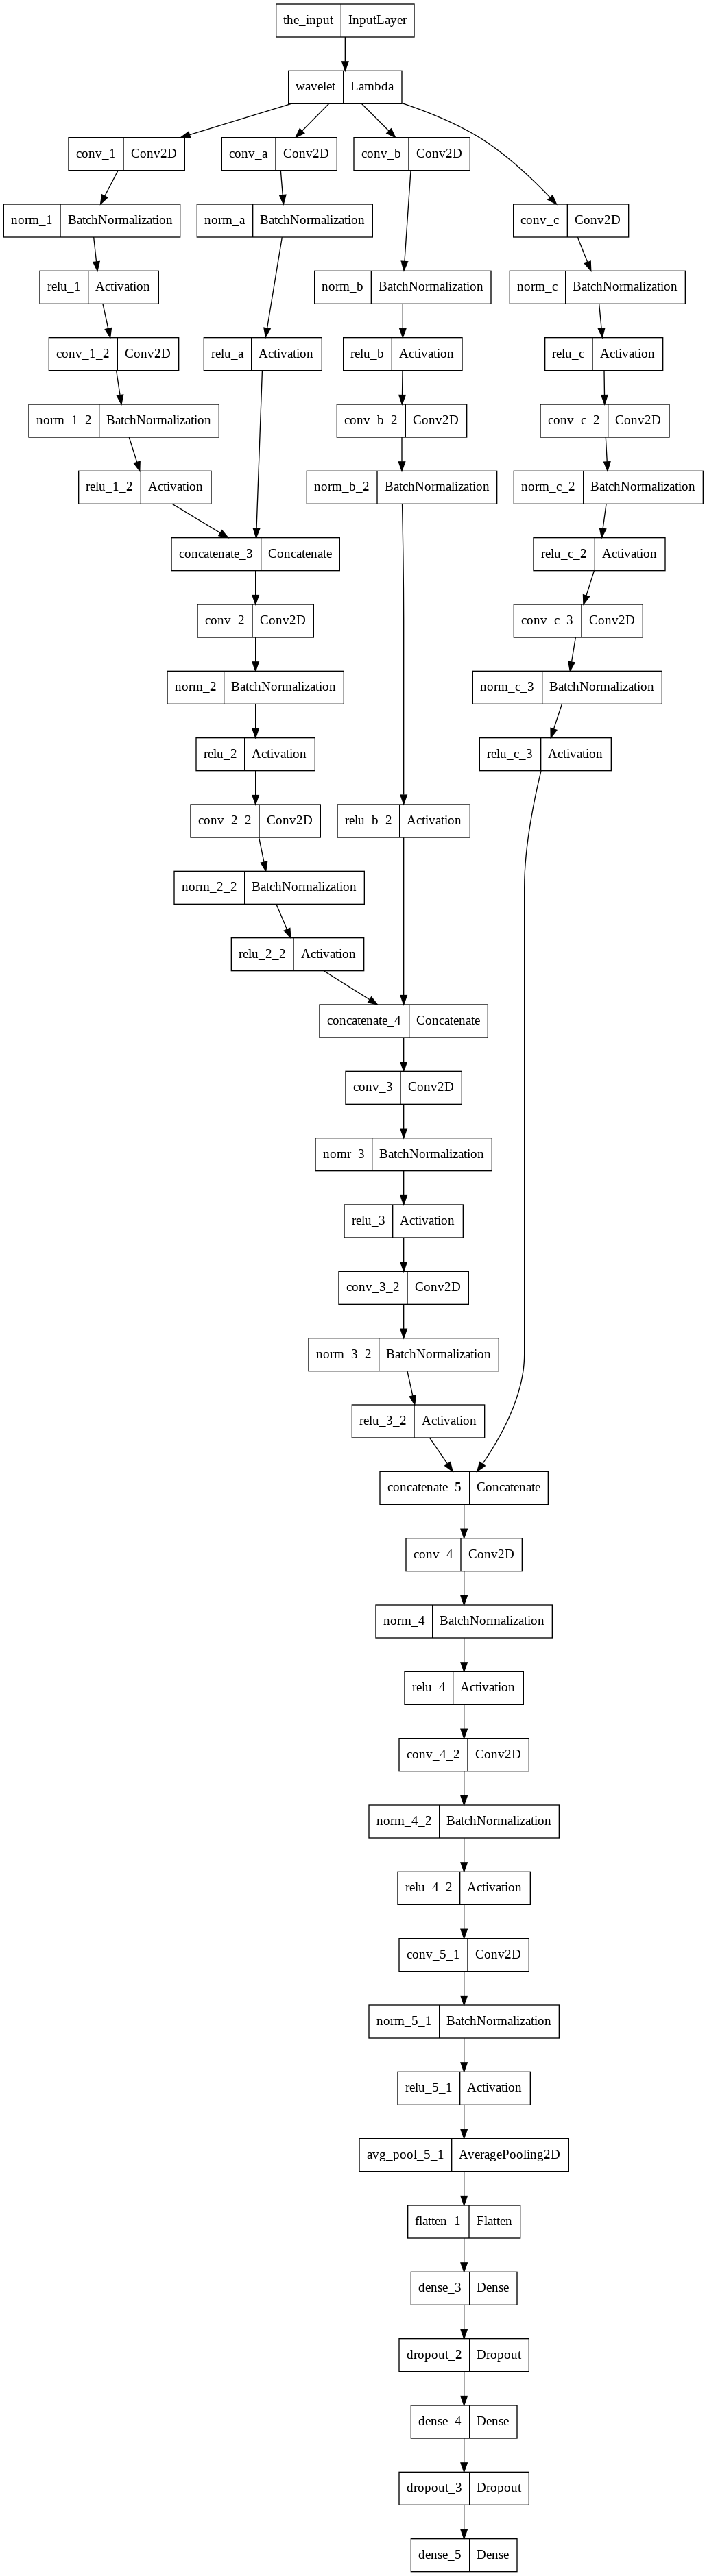

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image, display
display(Image('model.png'))

In [ ]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Tr, y=TrC, batch_size = 30, epochs=250, callbacks=callbacks_list)

Epoch 1/250
301/301 [==============================] - ETA: 0s - loss: 1.5010 - accuracy: 0.3525
Epoch 1: saving model to best-model.hdf5
301/301 [==============================] - 23s 18ms/step - loss: 1.5010 - accuracy: 0.3525
Epoch 2/250
301/301 [==============================] - ETA: 0s - loss: 1.2420 - accuracy: 0.5028
Epoch 2: saving model to best-model.hdf5
301/301 [==============================] - 5s 17ms/step - loss: 1.2420 - accuracy: 0.5028
Epoch 3/250
300/301 [============================>.] - ETA: 0s - loss: 0.9800 - accuracy: 0.6332
Epoch 3: saving model to best-model.hdf5
301/301 [==============================] - 5s 17ms/step - loss: 0.9799 - accuracy: 0.6331
Epoch 4/250
299/301 [============================>.] - ETA: 0s - loss: 0.7189 - accuracy: 0.7387
Epoch 4: saving model to best-model.hdf5
301/301 [==============================] - 5s 17ms/step - loss: 0.7182 - accuracy: 0.7389
Epoch 5/250
300/301 [============================>.] - ETA: 0s - loss: 0.5088 - accurac

In [ ]:
def cnn3D_1(input):
    cnv3D_1 = Conv3D(filters=24, padding='same' , kernel_size=(1, 1, 7), activation='relu')(input)
    cnv3D_1 = BatchNormalization()(cnv3D_1)
    cnv3D_1 = Activation('relu')(cnv3D_1)
    cnv3D_1 = Dropout(0.4)(cnv3D_1)
    return cnv3D_1
def cnn3D_2(input):
    cnn3D_2 = Conv3D(filters=24, padding='same' , kernel_size=(1, 1, 5), activation='relu')(input)
    cnn3D_2 = BatchNormalization()(cnn3D_2)
    cnn3D_2 = Activation('relu')(cnn3D_2)
    cnn3D_2 = Dropout(0.4)(cnn3D_2)
    return cnn3D_2
def cnn3D_3(input):
    cnn3D_3 = Conv3D(filters=24 , kernel_size=(1, 1, 3), activation='relu')(input)
    cnn3D_3 = BatchNormalization()(cnn3D_3)
    cnn3D_3 = Activation('relu')(cnn3D_3)
    cnn3D_3 = Dropout(0.4)(cnn3D_3)
    return cnn3D_3
def cnn3D2_1(input):
    cnv3D2_1 = Conv3D(filters=24, padding='same' , kernel_size=(7, 7, 1), activation='relu')(input)
    cnv3D2_1 = BatchNormalization()(cnv3D2_1)
    cnv3D2_1 = Activation('relu')(cnv3D2_1)
    cnv3D2_1 = Dropout(0.4)(cnv3D2_1)
    return cnv3D2_1
def cnn3D2_2(input):
    cnn3D2_2 = Conv3D(filters=24, padding='same' , kernel_size=(5, 5, 1), activation='relu')(input)
    cnn3D2_2 = BatchNormalization()(cnn3D2_2)
    cnn3D2_2 = Activation('relu')(cnn3D2_2)
    cnn3D2_2 = Dropout(0.4)(cnn3D2_2)
    return cnn3D2_2
def cnn3D2_3(input):
    cnn3D2_3 = Conv3D(filters=24,  kernel_size=(3, 3, 1), activation='relu')(input)
    cnn3D2_3 = BatchNormalization()(cnn3D2_3)
    cnn3D2_3 = Activation('relu')(cnn3D2_3)
    cnn3D2_3 = Dropout(0.4)(cnn3D2_3)
    return cnn3D2_3

In [ ]:
import tensorflow as tf


class channel_attention(tf.keras.layers.Layer):
    """
    channel attention module

    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    def __init__(self, ratio=8, **kwargs):
        super(channel_attention, self).__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super(channel_attention, self).get_config()
        config.update({'ratio': self.ratio})
        return config

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = tf.keras.layers.Dense(
            channel // self.ratio,
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        self.shared_layer_two = tf.keras.layers.Dense(
            channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros'
        )
        super(channel_attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        channel = inputs.get_shape().as_list()[-1]

        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
        max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        feature = tf.keras.layers.Add()([avg_pool, max_pool])
        feature = tf.keras.layers.Activation('sigmoid')(feature)

        return tf.keras.layers.multiply([inputs, feature])


class spatial_attention(tf.keras.layers.Layer):
    """ spatial attention module

    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    def __init__(self, kernel_size=7, **kwargs):
        super(spatial_attention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def get_config(self):
        config = super(spatial_attention, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

    def build(self, input_shape):
        self.conv2d = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=self.kernel_size,
            strides=1,
            padding='same',
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False
        )
        super(spatial_attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        avg_pool = tf.keras.layers.Lambda(
            lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True)
        )(inputs)
        max_pool = tf.keras.layers.Lambda(
            lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True)
        )(inputs)
        concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
        feature = self.conv2d(concat)

        return tf.keras.layers.multiply([inputs, feature])


def cbam_block(feature, ratio=8, kernel_size=7):
    """
    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    feature = channel_attention(ratio=ratio)(feature)

    return feature
def cbam_block1(feature, ratio=8, kernel_size=7):
    """
    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    feature = spatial_attention(kernel_size=kernel_size)(feature)

    return feature

In [ ]:


from keras.models import Model
import tensorflow as tf

from keras import optimizers
from keras.layers import (Dense, Conv2D, Conv3D, Reshape, MaxPooling2D, Flatten, Input,
                          concatenate,LSTM, Add, BatchNormalization, Dropout)
#
# ------- DATASET-SPECIFIC HYPERSPECTRAL ANALYSIS LAYERS -----
#

input1 = Input(shape=(15, 15, 20,1), name='T1_1')
print(input1.shape)
A = cnn3D_1(input1) #3DCNN 1

#A = BatchNormalization()(A)
Gh = cbam_block(A)  #Att

B = cnn3D_2(Gh)    #3DCNN 2
print('B shape=',B.shape)
Fh = cbam_block(B)  #Att

C = concatenate([Gh, Fh])
# X = cnn3D_3(C)    #3DCNN 3
V = cbam_block(C) #Att
# print(Mh.shape)
# V = Dropout(0.4)(Mh)
#print('MH shape=',MH.shape)
# V = concatenate([MH, Gh])



AB = cnn3D_1(input1)
GhB = cbam_block(AB)
BB = cnn3D_2(GhB)
print('BB shape=',BB.shape)
FhB = cbam_block(BB)
CB = concatenate([GhB, FhB])
# XB = cnn3D_3(CB)
VB = cbam_block(CB)
# print(MhB.shape)
# VB = Dropout(0.4)(MhB)
# VB = concatenate([MHB, GhB])

output1 = concatenate([V,VB])

# AC = cnn3D_1(output1)
# GhC = cbam_block(AC)
# BC = cnn3D_2(GhC)
# print('BC shape=', BC.shape)
# FhC = cbam_block(BC)
# CC = concatenate([GhC, FhC])
# XC = cnn3D_3(CC)
# VC = cbam_block(XC)
# # print(MhC.shape)
# # VC = Dropout(0.4)(MhC)

# # VC = concatenate([MHC, GhC])



# output1 = concatenate([V,VB,VC])
# print(output1.shape)


conv2_1_1 = cnn3D_1(input1)
Aconv2_1_1 = cbam_block1(conv2_1_1)
Bconv2_1_2 = cnn3D_2(Aconv2_1_1)
Cconv2_1_1 = cbam_block1(Bconv2_1_2)
CC2_1 = concatenate([Aconv2_1_1, Cconv2_1_1])
# conv2_1_3 = cnn3D_3(CC2_1)
V2 = cbam_block1(CC2_1)
# V2 = Dropout(0.4)(Aconv2_1_3)

# M1 = Reshape((Aconv2_1_1.shape[1], Aconv2_1_1.shape[2], Aconv2_1_1.shape[4], Aconv2_1_1.shape[3]))(Aconv2_1_1)
# M2 = Reshape((Aconv2_1_3_1.shape[1], Aconv2_1_3_1.shape[2], Aconv2_1_3_1.shape[4], Aconv2_1_3_1.shape[3]))(Aconv2_1_3_1)


# V2 = concatenate([M1, M2])


conv2_2_1 = cnn3D_1(input1)
Aconv2_2_1 = cbam_block1(conv2_2_1)
Bconv2_2_2 = cnn3D_2(Aconv2_2_1)
Cconv2_2_1 = cbam_block1(Bconv2_2_2)
CC2_2 = concatenate([Aconv2_2_1, Cconv2_2_1])
# conv2_2_3 = cnn3D_3(CC2_2)
V3 = cbam_block1(CC2_2)
# V3 = Dropout(0.4)(Aconv2_2_3)


# Aconv2_2_1 = Reshape((Aconv2_2_1.shape[1], Aconv2_2_1.shape[2], Aconv2_2_1.shape[4], Aconv2_2_1.shape[3]))(Aconv2_2_1)
# Aconv2_2_3_1 = Reshape((Aconv2_2_3_1.shape[1], Aconv2_2_3_1.shape[2], Aconv2_2_3_1.shape[4], Aconv2_2_3_1.shape[3]))(Aconv2_2_3_1)


# V3 = concatenate([Aconv2_2_1, Aconv2_2_3_1])
output2 = concatenate([V2,V3])

conv2_3_1 = cnn3D_1(output2)
Aconv2_3_1 = cbam_block1(conv2_3_1)
Bconv2_3_2 = cnn3D_2(Aconv2_3_1)
Cconv2_3_1 = cbam_block1(Bconv2_3_2)
CC2_3 = concatenate([Aconv2_3_1, Cconv2_3_1])
conv2_3_3 = cnn3D_3(CC2_3)
V4 = cbam_block1(conv2_3_3)
# V4 = Dropout(0.4)(Aconv2_3_3)


# Aconv2_3_1 = Reshape((Aconv2_3_1.shape[1], Aconv2_3_1.shape[2], Aconv2_3_1.shape[4], Aconv2_3_1.shape[3]))(Aconv2_3_1)
# Aconv2_3_3_1 = Reshape((Aconv2_3_3_1.shape[1], Aconv2_3_3_1.shape[2], Aconv2_3_3_1.shape[4], Aconv2_3_3_1.shape[3]))(Aconv2_3_3_1)



#V4 = concatenate([Aconv2_3_1, Aconv2_3_3_1])


# output2 = concatenate([V2,V3,V4])
print('Output 2 = ',output2.shape)

# VC = Reshape((VC.shape[1], VC.shape[2], VC.shape[4], VC.shape[3]))(VC)
# V4 = Reshape((V4.shape[1], V4.shape[2], V4.shape[4], V4.shape[3]))(V4)

concat1 = concatenate([output1, output2])

print('concat  = ',concat1.shape)
# concat1 = Dropout(0.5)(concat)


resh = Reshape((concat1.shape[1], concat1.shape[2] * concat1.shape[3], concat1.shape[4]))(concat1)
print('resh  = ',resh.shape)



#filter11 = Conv3D(filters=128, kernel_size=(3, 3), activation='relu')(input1)
filter1 = Conv2D(filters= 16 , kernel_size=(5, 5) , activation='relu')(resh)
print('filter1  = ',filter1.shape)


## Faltten 3D Convolutional Layer

flatten_layer = Flatten()(filter1)
output_units = 5


# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=32, activation='relu')(flatten_layer)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


## Fully Connected Layers
# dense_layer1 = Dense(units=204, activation='relu')(flatten_layer)
# output_layer = Dense(units=output_units, activation='softmax')(dense_layer1)

(None, 15, 15, 20, 1)
B shape= (None, 15, 15, 20, 24)
BB shape= (None, 15, 15, 20, 24)
Output 2 =  (None, 15, 15, 20, 96)
concat  =  (None, 15, 15, 20, 192)
resh  =  (None, 15, 300, 192)
filter1  =  (None, 11, 296, 16)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=[input1], outputs=output_layer, name= '3DCNNAttention')
model.summary()

# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-05)
model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])

Model: "3DCNNAttention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 T1_1 (InputLayer)              [(None, 15, 15, 20,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 15, 15, 20,   192         ['T1_1[0][0]']                   
                                24)                                                               
                                                                                                  
 conv3d_2 (Conv3D)              (None, 15, 15, 20,   192         ['T1_1[0][0]']                   
                                24)                                                  

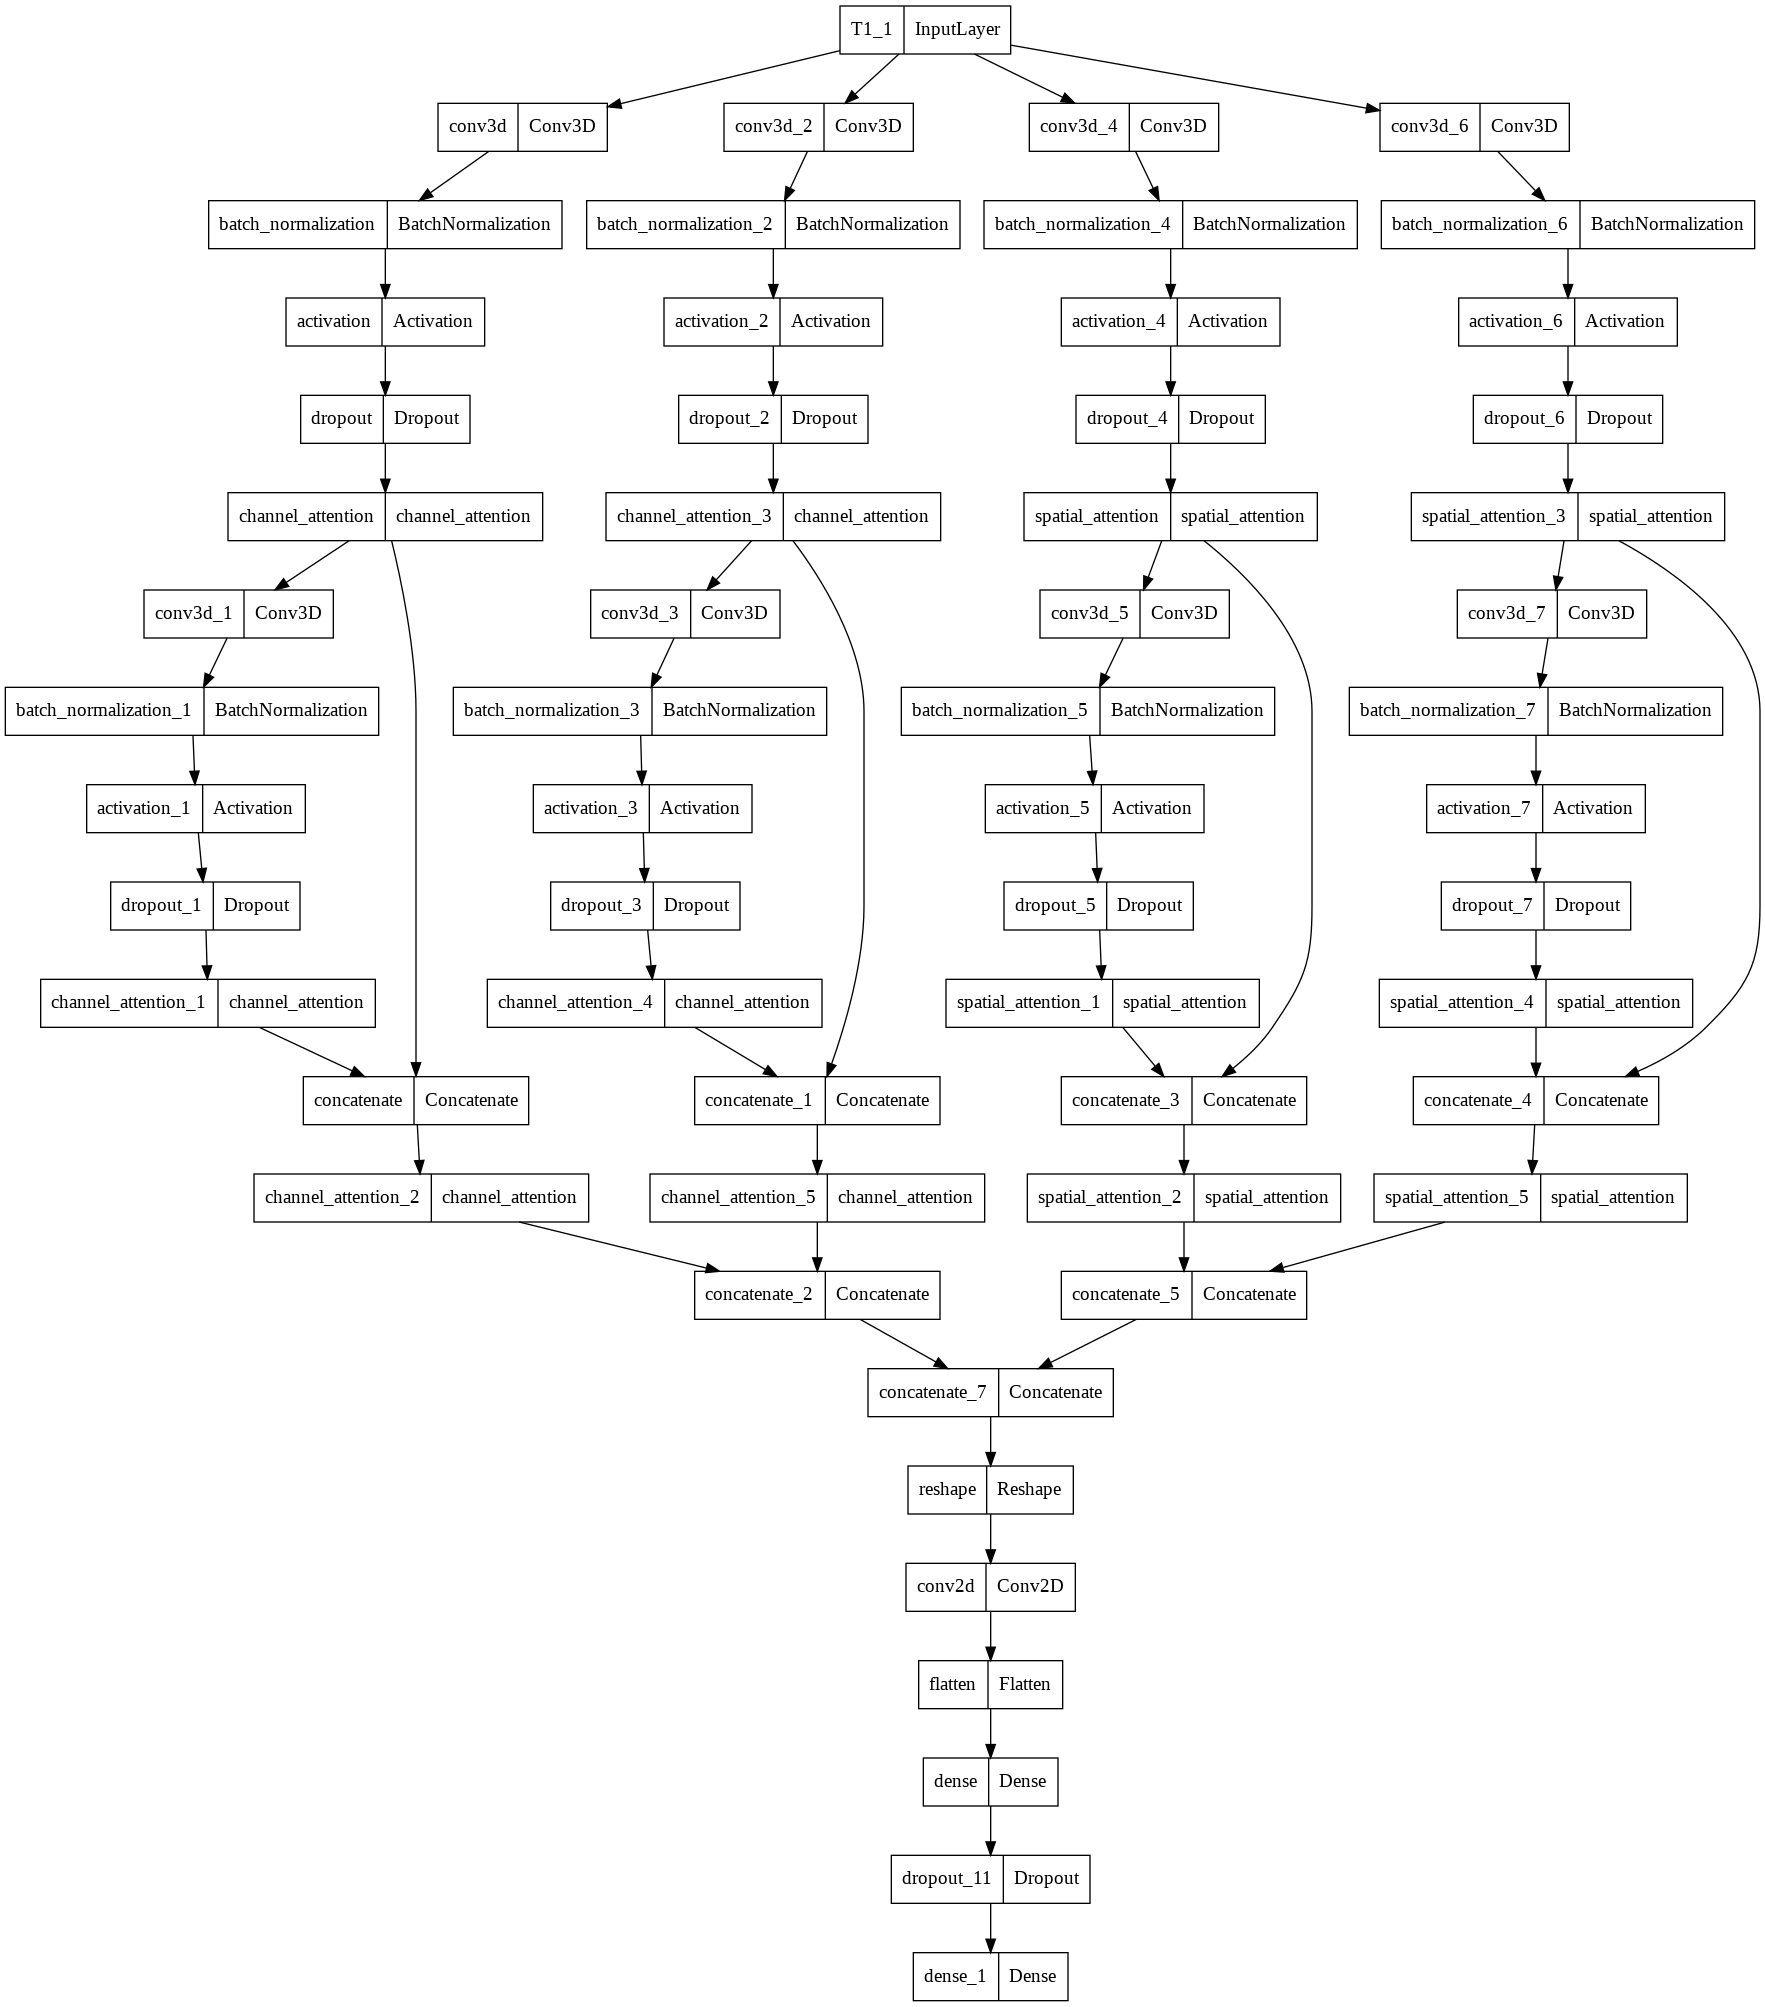

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image, display
display(Image('model.png'))

In [ ]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

savedir  = Path("/content/drive/MyDrive/Classification3/")
ckpt_callbacks = ModelCheckpoint(savedir/'savedmodel-{epoch:02d}-{accuracy:.2f}.hdf5',
                                 monitor = 'accuracy',
                                 save_weights_only = True,
                                 )

In [ ]:
savedir1  = Path("/content/drive/MyDrive/Classification/")

In [ ]:
checkpoint_path = savedir1/'savedmodel-97-0.75.hdf5'

In [ ]:
checkpoint_path

PosixPath('/content/drive/MyDrive/Classification/savedmodel-97-0.75.hdf5')

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
import os

In [ ]:
def get_inint_epoch(checkpoint_path):
  return int(os.path.split('-')[-2].split('.')[-1])

In [ ]:
get_inint_epoch(checkpoint_path)

ValueError: ignored

In [ ]:
## Training Time and Fit the Model
start = time.time()
history = model.fit(x=Tr, y=TrC, batch_size= 64, validation_split=0.2, epochs= 150, callbacks = [ckpt_callbacks]) # , validation_data=(Xvalid, yvalid)
end = time.time()


Tr_Time = end - start
print('Train time = ', Tr_Time)

Epoch 1/150
226/226 [==============================] - 72s 253ms/step - loss: 1.6168 - accuracy: 0.3020 - val_loss: 1.5519 - val_accuracy: 0.3280
Epoch 2/150
226/226 [==============================] - 56s 247ms/step - loss: 1.5471 - accuracy: 0.3220 - val_loss: 1.4760 - val_accuracy: 0.3618
Epoch 3/150
226/226 [==============================] - 56s 248ms/step - loss: 1.4485 - accuracy: 0.3779 - val_loss: 1.3702 - val_accuracy: 0.4147
Epoch 4/150
226/226 [==============================] - 56s 249ms/step - loss: 1.2997 - accuracy: 0.4495 - val_loss: 1.3048 - val_accuracy: 0.4568
Epoch 5/150
226/226 [==============================] - 56s 248ms/step - loss: 1.1340 - accuracy: 0.5311 - val_loss: 1.2779 - val_accuracy: 0.4823
Epoch 6/150
226/226 [==============================] - 56s 248ms/step - loss: 0.9750 - accuracy: 0.5984 - val_loss: 1.3656 - val_accuracy: 0.4787
Epoch 7/150
226/226 [==============================] - 56s 248ms/step - loss: 0.8323 - accuracy: 0.6609 - val_loss: 1.3501 -

KeyboardInterrupt: ignored

In [ ]:
model.save( savedir / 'LSTMCNNATT2.h5')

In [ ]:
savedir  = Path("/content/drive/MyDrive/Classification2/")

In [ ]:
from keras.models import load_model

In [ ]:
# from keras.utils.generic_utils import get_custom_objects
model = load_model(savedir / 'LSTMCNNATT1.h5', custom_objects={'channel_attention': channel_attention,'spatial_attention':spatial_attention})

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping


In [ ]:
checkpoint_path =  savedir/'savedmodel-50-0.99.hdf5'

In [ ]:
model.load_weights(checkpoint_path)

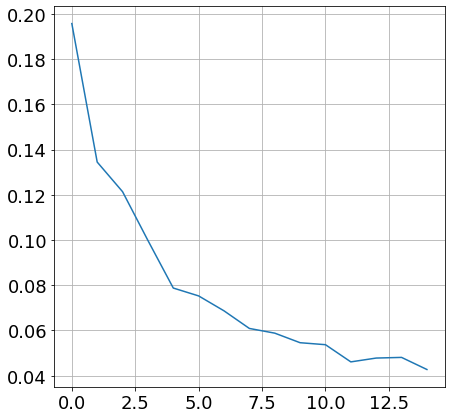

In [ ]:
## Plot Training loss and Accuracy
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 18})
plt.grid()
plt.plot(history.history['loss'])

In [ ]:
TeC.shape

(81219, 5)

In [ ]:
import time

In [ ]:
Y_pred_test = model.predict(Te)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(TeC, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     25669
           1       0.92      0.87      0.90     10865
           2       0.90      0.90      0.90     11614
           3       0.91      0.92      0.91     14275
           4       0.92      0.93      0.92     18796

    accuracy                           0.91     81219
   macro avg       0.91      0.91      0.91     81219
weighted avg       0.91      0.91      0.91     81219



In [ ]:
Y_pred_test.shape

(81219, 5)

In [ ]:
kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Y_pred_test, axis=1))

In [ ]:
kappa

0.831368108131769

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['1', '2', '3', '4'
                        ,'5']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Te,TeC,'IP')


2539/2539 [==============================] - 23s 9ms/step - loss: 0.8686 - accuracy: 0.8694


In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
# HSI = np.load('/content/drive/MyDrive/HSI.npy')
# print(HSI.shape)
GT1 = np.load('/content/drive/MyDrive/GT.npy')
# print(GT.shape)

In [ ]:
ground_truth = spectral.imshow(classes = GT1,figsize =(100,100))

In [ ]:
## Computing and Writing the Accuacy in .txt file
classification, confusion, oa, each_acc, aa, kappa, target_names, y_pred, Time = reports(Te, TeC, 'IP')
classification = str(classification)
confusion = str(confusion)
print(classification), print('OA = ', oa), print('kappa = ', kappa), print('AA = ', aa), print('Tr_Time = ', Tr_Time), print('Time = ', Time)

ValueError: ignored